In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

time: 332 ms (started: 2022-09-28 17:45:50 +00:00)


In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

100% 1.56G/1.56G [00:06<00:00, 248MB/s]
100% 1.56G/1.56G [00:06<00:00, 258MB/s]
time: 7.75 s (started: 2022-09-28 17:45:51 +00:00)


In [ ]:
!unzip new-york-city-taxi-fare-prediction

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
time: 56.6 s (started: 2022-09-28 17:45:59 +00:00)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import activations

time: 3.05 s (started: 2022-09-28 17:47:08 +00:00)


In [ ]:
train = pd.read_csv("/content/train.csv", nrows = 1000000)
test = pd.read_csv("/content/test.csv")
test = pd.read_csv("https://raw.githubusercontent.com/gagan-iitb/CS550/main/Prog_Assignments/assignment_3_dataset/test_data_ny_taxi_fare_prediction.csv")

time: 2.34 s (started: 2022-09-28 17:47:32 +00:00)


In [ ]:
#drop the missing values
train = train.dropna()

train=train[(train[['fare_amount']]>0).all(1)]

train=train[(train[['dropoff_longitude']]>-75.082045).all(1)]
train=train[(train[['dropoff_longitude']]<-71.582045).all(1)]

train=train[(train[['pickup_longitude']]>-75.082045).all(1)]
train=train[(train[['pickup_longitude']]<-71.582045).all(1)]

train=train[(train[['dropoff_latitude']]>38.4548).all(1)]
train=train[(train[['dropoff_latitude']]<42.4548).all(1)]

train=train[(train[['pickup_latitude']]>38.4548).all(1)]
train=train[(train[['pickup_latitude']]<42.4548).all(1)]

train=train[(train[['passenger_count']]<=6).all(1)]
train=train[(train[['passenger_count']]>0).all(1)]

def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])

        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])

        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')


train=train[(train[['H_Distance']]<=100).all(1)] # keeping records with haversine distance less than 100kms
train=train[(train[['H_Distance']]>0.35).all(1)]

train_=train[(train[['H_Distance']]<=20).all(1)] # keeping records with haversine distance less than 100kms
train__=train[(train[['H_Distance']]>=75).all(1)]

tup = [train_[:int(0.5*len(train_))]]
for _ in range(120):
  tmp = train__.copy(deep=True)
  tmp['fare_amount'] = np.array(tmp['fare_amount']) + np.random.normal(0, 1, len(tmp))
  tup.append(tmp)
del tmp

# print(len(train_), len(train__))
# input()


cols = train.columns
train_FOR_TEST = np.vstack(tuple(tup))
train_FOR_TEST = pd.DataFrame(train_FOR_TEST, columns = cols)

del tup

train = train.sample(frac=1)
train.reset_index(drop=True)

train_FOR_TEST = train_FOR_TEST.sample(frac=1)
train_FOR_TEST.reset_index(drop=True)

# train['key'] = pd.to_datetime(train['key'])
train_FOR_TEST['pickup_datetime']  = pd.to_datetime(train_FOR_TEST['pickup_datetime'])

# train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

# test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])


data = [train,test,train_FOR_TEST]
for i in data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

dist_vec = np.array(test['H_Distance'])/np.max(test['H_Distance']) #+ np.array(test['fare_amount'])/np.max(test['fare_amount'])

train = train.sample(frac=1)
train.reset_index(drop=True)

train_FOR_TEST = train_FOR_TEST.sample(frac=1)
train_FOR_TEST.reset_index(drop=True)


# DATA SCALING

train_X = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'H_Distance', 'Year', 'Month', 'Day of Week', 'Hour', 'fare_amount']]
# train_y = train[['fare_amount']]

standard_scale_attribs = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Hour']
one_hot_encoded_attribs = ['Day of Week']
min_max_scale_attribs = ['Year']
no_change_attribs = ['H_Distance', 'passenger_count', 'fare_amount']
train_X = train_X.reset_index(drop=True)
from sklearn.preprocessing import OneHotEncoder
Train_X_OHE = OneHotEncoder().fit_transform(train_X[one_hot_encoded_attribs]).toarray()
Train_X_OHE=pd.DataFrame(Train_X_OHE)
Train_X_OHE.columns=['Day_'+str(i) for i in range(7)]
from sklearn.preprocessing import StandardScaler
Train_X_SS = StandardScaler().fit_transform(train_X[standard_scale_attribs])
Train_X_SS=pd.DataFrame(Train_X_SS)
Train_X_SS.columns = standard_scale_attribs
from sklearn.preprocessing import MinMaxScaler
Train_X_MM = MinMaxScaler().fit_transform(train_X[min_max_scale_attribs])
Train_X_MM=pd.DataFrame(Train_X_MM)
Train_X_MM.columns = min_max_scale_attribs
train = train.reset_index(drop=True)
train = pd.concat([train_X[no_change_attribs], Train_X_OHE, Train_X_MM, Train_X_SS], axis=1)


train = train.sample(frac=1)
train.reset_index(drop=True)

train_FOR_TEST = train_FOR_TEST.sample(frac=1)
train_FOR_TEST.reset_index(drop=True)

train['H_Distance'] = train['H_Distance']/100
# test['H_Distance'] = test['H_Distance']/100

y_train = train[['fare_amount']]
X_train = train.drop(['fare_amount'], axis=1)
X_train.to_csv('/content/drive/MyDrive/Assg3_Folder/X_train_Normal.csv')
y_train.to_csv('/content/drive/MyDrive/Assg3_Folder/y_train_Normal.csv')

# DATA SCALING

train_X = train_FOR_TEST[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'H_Distance', 'Year', 'Month', 'Day of Week', 'Hour', 'fare_amount']]
# train_y = train[['fare_amount']]

standard_scale_attribs = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Hour']
one_hot_encoded_attribs = ['Day of Week']
min_max_scale_attribs = ['Year']
no_change_attribs = ['H_Distance', 'passenger_count', 'fare_amount']
train_X = train_X.reset_index(drop=True)
from sklearn.preprocessing import OneHotEncoder
enc_OHE = OneHotEncoder()
Train_X_OHE = enc_OHE.fit_transform(train_X[one_hot_encoded_attribs]).toarray()
Train_X_OHE=pd.DataFrame(Train_X_OHE)
Train_X_OHE.columns=['Day_'+str(i) for i in range(7)]
from sklearn.preprocessing import StandardScaler
enc_SS = StandardScaler()
Train_X_SS = enc_SS.fit_transform(train_X[standard_scale_attribs])
Train_X_SS=pd.DataFrame(Train_X_SS)
Train_X_SS.columns = standard_scale_attribs
from sklearn.preprocessing import MinMaxScaler
enc_MM = MinMaxScaler()
Train_X_MM = enc_MM.fit_transform(train_X[min_max_scale_attribs])
Train_X_MM=pd.DataFrame(Train_X_MM)
Train_X_MM.columns = min_max_scale_attribs
train_FOR_TEST = train_FOR_TEST.reset_index(drop=True)
train_FOR_TEST = pd.concat([train_X[no_change_attribs], Train_X_OHE, Train_X_MM, Train_X_SS], axis=1)

train_FOR_TEST['H_Distance'] = train_FOR_TEST['H_Distance']/100
# test['H_Distance'] = test['H_Distance']/100


train = train.sample(frac=1)
train.reset_index(drop=True)

train_FOR_TEST = train_FOR_TEST.sample(frac=1)
train_FOR_TEST.reset_index(drop=True)

y_train_ = train_FOR_TEST[['fare_amount']]
X_train_ = train_FOR_TEST.drop(['fare_amount'], axis=1)
X_train_.to_csv('/content/drive/MyDrive/Assg3_Folder/X_train_FOR_TEST.csv')
y_train_.to_csv('/content/drive/MyDrive/Assg3_Folder/y_train_FOR_TEST.csv')

# del train_FOR_TEST, X_train_, y_train_


time: 3min 14s (started: 2022-09-28 17:47:40 +00:00)


In [ ]:
train_FOR_TEST

,H_Distance,passenger_count,fare_amount,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Year,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Hour
218168,0.014501,4,6.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,-0.237279,-0.069201,-0.038351,0.066880,0.228119
351108,0.020115,2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,-0.217676,-0.266261,0.004789,-0.071781,0.998309
237421,0.005972,1,5.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.833333,-0.159551,-0.189598,-0.052160,-0.190781,-0.233995
395962,0.009123,1,4.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,-0.209896,-0.077495,-0.362647,0.026642,-1.312261
302450,0.052338,4,13.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,-0.217563,-0.330076,0.229791,0.272807,-1.004185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464629,0.912309,1,6.177066,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.500000,-0.176201,-0.343949,14.238564,-0.147489,-0.542071
81854,0.013015,2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.833333,-0.217276,-0.327428,-0.436015,-0.347292,1.460423
320042,0.006158,1,4.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,-0.188775,-0.087655,-0.109391,-0.057313,-0.696109
173463,0.015639,4,11.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,-0.193747,-0.082879,-0.433474,-0.045392,1.460423


time: 28.8 ms (started: 2022-09-28 17:51:02 +00:00)


In [ ]:
test

,test_id,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,0,26:21.0,2009-06-15 17:26:21+00:00,-74.844311,40.721319,-73.841610,40.712278,1,84.512588,2009,6,15,0,17
1,1,52:16.0,2010-01-05 16:52:16+00:00,-75.016048,40.711303,-73.979268,40.782004,1,87.692608,2010,1,5,1,16
2,2,35:00.0,2011-08-18 00:35:00+00:00,-74.982738,40.761270,-73.991242,40.750562,2,83.521640,2011,8,18,3,0
3,3,30:42.0,2012-04-21 04:30:42+00:00,-74.987130,40.733143,-73.991567,40.758092,1,83.914567,2012,4,21,5,4
4,4,51:00.0,2010-03-09 07:51:00+00:00,-74.968095,40.768008,-73.956655,40.783762,1,85.185424,2010,3,9,1,7
5,5,50:45.0,2011-01-06 09:50:45+00:00,-75.000964,40.731630,-73.972892,40.758233,1,86.658701,2011,1,6,3,9
6,6,35:00.0,2012-11-20 20:35:00+00:00,-74.980002,40.751662,-73.973802,40.764842,1,84.761341,2012,11,20,1,20
7,7,22:00.0,2012-01-04 17:22:00+00:00,-74.951300,40.774138,-73.990095,40.751048,1,80.994355,2012,1,4,2,17
8,8,10:00.0,2012-12-03 13:10:00+00:00,-75.006462,40.726713,-73.993078,40.731628,1,85.392826,2012,12,3,0,13
9,9,11:00.0,2009-09-02 01:11:00+00:00,-74.980658,40.733873,-73.991540,40.758138,2,83.368947,2009,9,2,2,1


time: 24.5 ms (started: 2022-09-28 17:55:51 +00:00)


In [ ]:
x=dist_vec.sort()
plt.plot(dist_vec)

In [ ]:
# X_train = train.drop(['key', 'pickup_datetime'], axis=1)
# y_train
y_train = np.asarray(y_train).astype('float32')
X_train = np.asarray(X_train).astype('float32')

### A. Baseline Neural Network

> *   SGD Optimizer
*   2 Hidden Layer have Sigmoid activation function

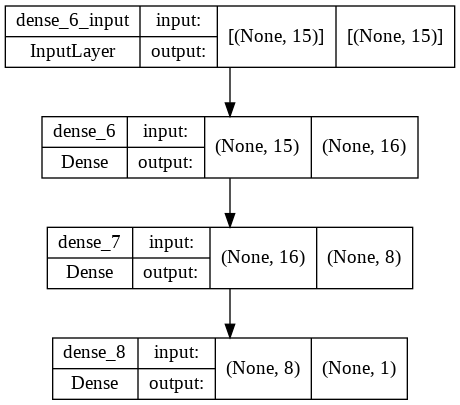

time: 206 ms (started: 2022-09-27 17:20:42 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(8, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/10
5935/5935 [==============================] - 22s 4ms/step - loss: 1.8050 - mean_absolute_percentage_error: 16.7647 - mean_absolute_error: 1.8050 - mean_squared_error: 13.8865 - val_loss: 1.8133 - val_mean_absolute_percentage_error: 16.0417 - val_mean_absolute_error: 1.8133 - val_mean_squared_error: 14.3981
Epoch 2/10
5935/5935 [==============================] - 22s 4ms/step - loss: 1.7860 - mean_absolute_percentage_error: 16.5416 - mean_absolute_error: 1.7860 - mean_squared_error: 13.6951 - val_loss: 1.8091 - val_mean_absolute_percentage_error: 16.1201 - val_mean_absolute_error: 1.8091 - val_mean_squared_error: 14.2320
Epoch 3/10
5935/5935 [==============================] - 19s 3ms/step - loss: 1.7739 - mean_absolute_percentage_error: 16.4134 - mean_absolute_error: 1.7739 - mean_squared_error: 13.5023 - val_loss: 1.7770 - val_mean_absolute_percentage_error: 16.2121 - val_mean_absolute_error: 1.7770 - val_mean_squared_error: 13.7542
Epoch 4/10
5935/5935 [=====================

In [ ]:
loss_val=pd.DataFrame(history.history)#.plot(figsize=(16,14))
loss_val[-1:]
# loss_val.plot(figsize=(16,14))
# plt.show()

,loss,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_percentage_error,val_mean_absolute_error,val_mean_squared_error
9,1.703773,15.754442,1.703773,12.648042,1.705596,15.497397,1.705596,12.978741


time: 15.4 ms (started: 2022-09-27 17:25:10 +00:00)


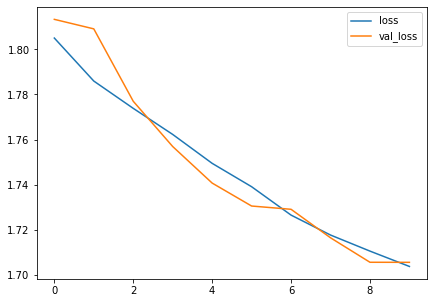

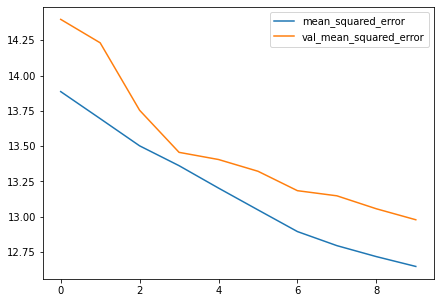

time: 330 ms (started: 2022-09-27 17:25:13 +00:00)


In [ ]:
loss_val[['loss', 'val_loss']].plot(figsize=(14/2, 5))
loss_val[['mean_squared_error', 'val_mean_squared_error']].plot(figsize=(14/2, 5))

In [ ]:
def CI_95():
  y_pred = model.predict(X_train)
  print(np.mean(np.abs(y_pred-y_train)) - 1.96*np.std(np.abs(y_pred-y_train)), np.mean(np.abs(y_pred-y_train)) + 1.96*np.std(np.abs(y_pred-y_train)))
  print(np.mean((y_pred-y_train)**2) - 1.96*np.std((y_pred-y_train)**2), np.mean((y_pred-y_train)**2) + 1.96*np.std((y_pred-y_train)**2))
  print(np.mean(np.abs(y_pred-y_train)/y_train) - 1.96*np.std(np.abs(y_pred-y_train)/y_train), np.mean(np.abs(y_pred-y_train)/y_train) + 1.96*np.std(np.abs(y_pred-y_train/y_train)))
  # input()
  print('Confidence Intervals:\n')
  print('MSE : [{}, {}]'.format(np.mean(loss_val['val_mean_squared_error'])-1.96*np.std(loss_val['val_mean_squared_error']), np.mean(loss_val['val_mean_squared_error'])+1.96*np.std(loss_val['val_mean_squared_error'])))
  print('MAE : [{}, {}]'.format(np.mean(loss_val['val_mean_absolute_error'])-1.96*np.std(loss_val['val_mean_absolute_error']), np.mean(loss_val['val_mean_absolute_error'])+1.96*np.std(loss_val['val_mean_absolute_error'])))
  print('MAPE : [{}, {}]'.format(np.mean(loss_val['val_mean_absolute_percentage_error'])-1.96*np.std(loss_val['val_mean_absolute_percentage_error']), np.mean(loss_val['val_mean_absolute_percentage_error'])+1.96*np.std(loss_val['val_mean_absolute_percentage_error'])))

CI_95()

-4.433460783958435 7.835586380958557
-539.4261191177368 564.8053896713257
-4.027287623882294 17.41751487970352
Confidence Intervals:

MSE : [12.586775028061897, 14.400492084670038]
MAE : [1.674540287247234, 1.822341340789265]
MAPE : [15.159324440829282, 16.42646008981037]
time: 41.1 s (started: 2022-09-27 17:37:12 +00:00)


### B. 6 Hidden layers with sigmoid activation and *ADAM* Optimizer

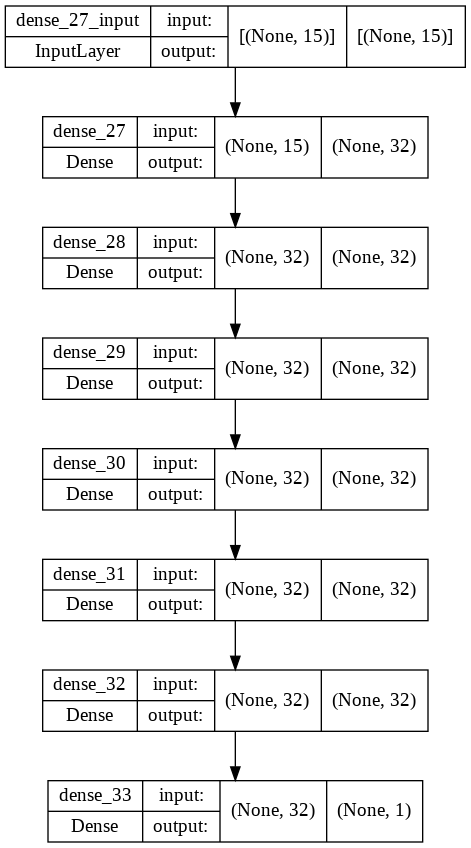

time: 1min 33s (started: 2022-09-26 13:19:15 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(32, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 12, batch_size = 20, validation_split=0.2, shuffle=True)

loss_val=pd.DataFrame(history.history)
loss_val[-1:]

Epoch 1/12
37982/37982 [==============================] - 147s 4ms/step - loss: 2.6362 - mean_absolute_percentage_error: 22.8221 - mean_absolute_error: 2.6362 - mean_squared_error: 31.1765 - val_loss: 1.8778 - val_mean_absolute_percentage_error: 15.9808 - val_mean_absolute_error: 1.8778 - val_mean_squared_error: 16.7615
Epoch 2/12
37982/37982 [==============================] - 159s 4ms/step - loss: 1.8079 - mean_absolute_percentage_error: 16.7308 - mean_absolute_error: 1.8079 - mean_squared_error: 13.7040 - val_loss: 1.7813 - val_mean_absolute_percentage_error: 15.8293 - val_mean_absolute_error: 1.7813 - val_mean_squared_error: 15.4048
Epoch 3/12
37982/37982 [==============================] - 145s 4ms/step - loss: 1.7405 - mean_absolute_percentage_error: 16.1361 - mean_absolute_error: 1.7405 - mean_squared_error: 13.0027 - val_loss: 1.7449 - val_mean_absolute_percentage_error: 15.0932 - val_mean_absolute_error: 1.7449 - val_mean_squared_error: 15.1465
Epoch 4/12
37982/37982 [==========

,loss,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_percentage_error,val_mean_absolute_error,val_mean_squared_error
11,1.56006,14.660363,1.56006,11.20781,1.557517,14.160449,1.557517,13.183477


time: 29min 22s (started: 2022-09-26 13:20:49 +00:00)


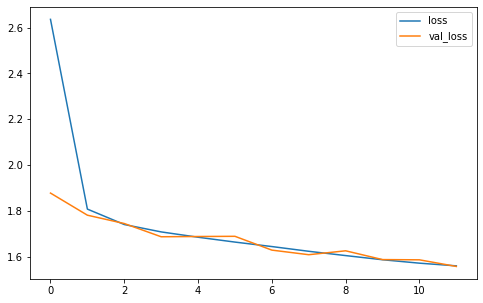

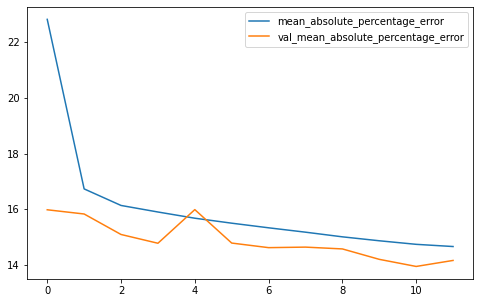

time: 308 ms (started: 2022-09-26 13:50:11 +00:00)


In [ ]:
loss_val[['loss', 'val_loss']].plot(figsize=(8,5))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(8,5))


In [ ]:
CI_95()

Confidence Intervals:

MSE : [12.415060652856663, 16.230468617315456]
MAE : [1.496649435989834, 1.8472122035098304]
MAPE : [13.558643474741896, 16.206636454101286]
time: 5.32 ms (started: 2022-09-26 13:50:11 +00:00)


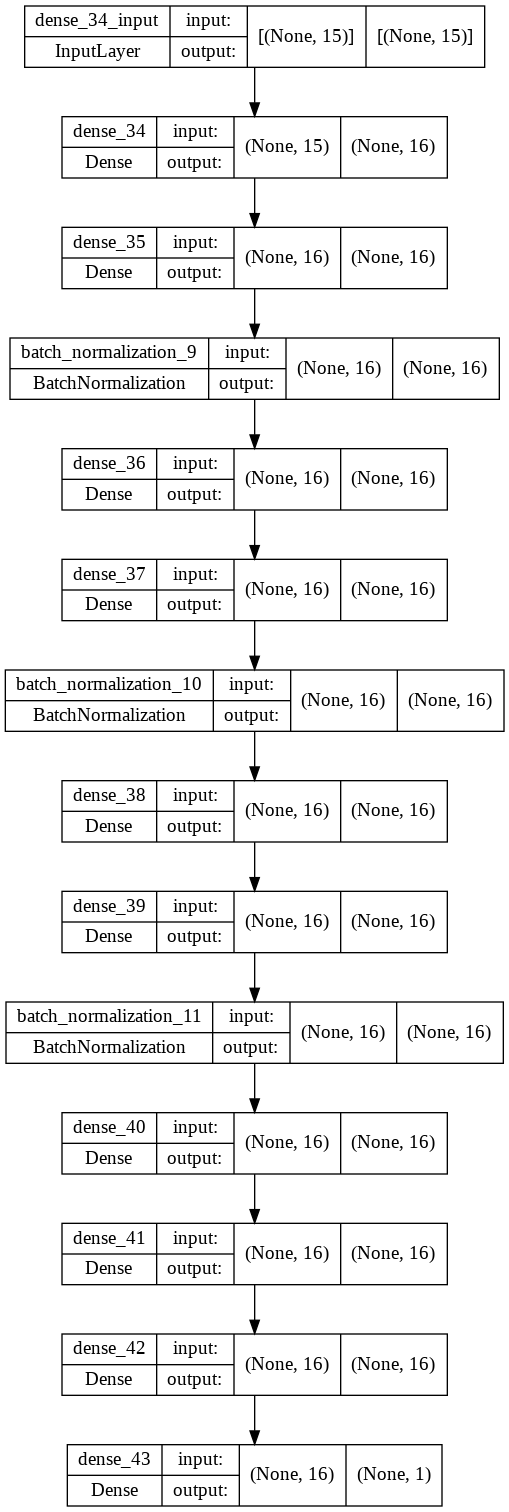

time: 296 ms (started: 2022-09-26 13:50:11 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(16, activation=activations.sigmoid),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 20, validation_split=0.2, shuffle=True)

loss_val=pd.DataFrame(history.history)
loss_val[-1:]

Epoch 1/10
37982/37982 [==============================] - 216s 6ms/step - loss: 11.3618 - mean_absolute_percentage_error: 100.0000 - mean_absolute_error: 11.3618 - mean_squared_error: 218.1357 - val_loss: 11.3821 - val_mean_absolute_percentage_error: 100.0000 - val_mean_absolute_error: 11.3821 - val_mean_squared_error: 221.1723
Epoch 2/10
37982/37982 [==============================] - 217s 6ms/step - loss: 11.3618 - mean_absolute_percentage_error: 100.0000 - mean_absolute_error: 11.3618 - mean_squared_error: 218.1367 - val_loss: 11.3821 - val_mean_absolute_percentage_error: 100.0000 - val_mean_absolute_error: 11.3821 - val_mean_squared_error: 221.1723
Epoch 3/10
37982/37982 [==============================] - 218s 6ms/step - loss: 11.3618 - mean_absolute_percentage_error: 100.0000 - mean_absolute_error: 11.3618 - mean_squared_error: 218.1372 - val_loss: 11.3821 - val_mean_absolute_percentage_error: 100.0000 - val_mean_absolute_error: 11.3821 - val_mean_squared_error: 221.1723
Epoch 4/10

,loss,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_percentage_error,val_mean_absolute_error,val_mean_squared_error
9,11.361797,99.999992,11.3618,218.136536,11.382106,100.0,11.382106,221.172272


time: 36min 23s (started: 2022-09-26 13:50:12 +00:00)


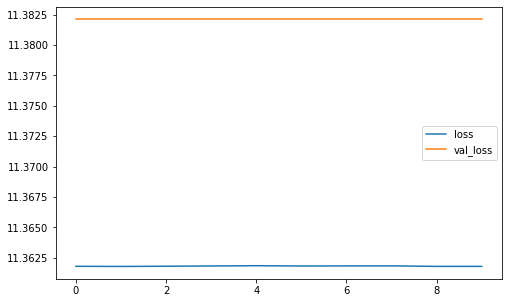

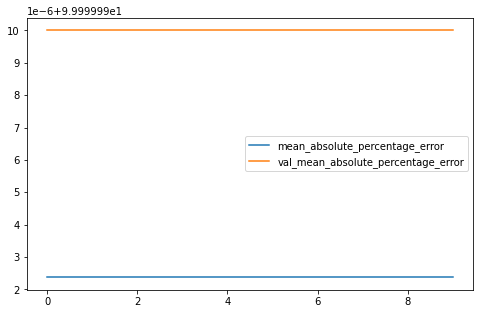

time: 361 ms (started: 2022-09-26 14:26:35 +00:00)


In [ ]:
loss_val[['loss', 'val_loss']].plot(figsize=(8,5))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(8,5))


In [ ]:
CI_95()

Confidence Intervals:

MSE : [221.17227172851562, 221.17227172851562]
MAE : [11.382105827331543, 11.382105827331543]
MAPE : [100.0, 100.0]
time: 3.17 ms (started: 2022-09-26 14:26:35 +00:00)


### C. 8 Hidden layers with 32 neurons each - elu activation and *ADAM* Optimizer

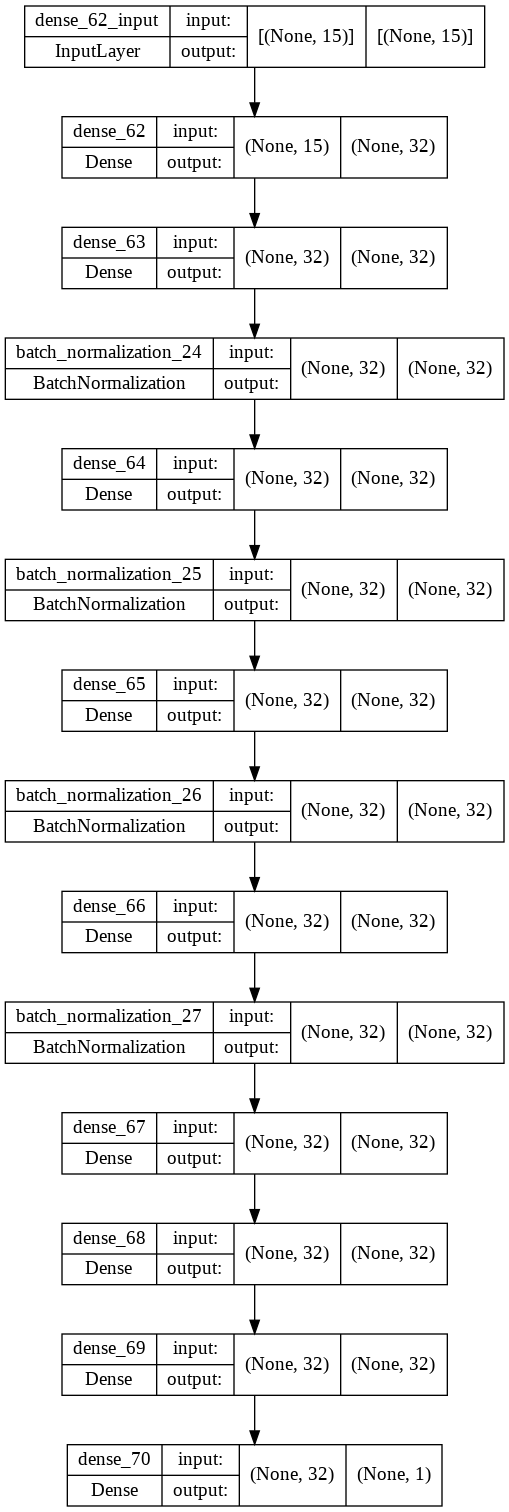

time: 360 ms (started: 2022-09-26 15:43:15 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 15, batch_size = 20, validation_split=0.2, shuffle=True, callbacks=[callback])

Epoch 1/15
37982/37982 [==============================] - 233s 6ms/step - loss: 2.1374 - mean_absolute_percentage_error: 19.9772 - mean_absolute_error: 2.1374 - mean_squared_error: 16.6976 - val_loss: 1.8248 - val_mean_absolute_percentage_error: 16.4112 - val_mean_absolute_error: 1.8248 - val_mean_squared_error: 15.6432 - lr: 9.0484e-04
Epoch 2/15
37982/37982 [==============================] - 233s 6ms/step - loss: 1.8597 - mean_absolute_percentage_error: 17.2685 - mean_absolute_error: 1.8597 - mean_squared_error: 13.6957 - val_loss: 1.6922 - val_mean_absolute_percentage_error: 14.6686 - val_mean_absolute_error: 1.6922 - val_mean_squared_error: 14.3719 - lr: 8.1873e-04
Epoch 3/15
37982/37982 [==============================] - 232s 6ms/step - loss: 1.7899 - mean_absolute_percentage_error: 16.7176 - mean_absolute_error: 1.7899 - mean_squared_error: 13.0457 - val_loss: 1.6450 - val_mean_absolute_percentage_error: 14.5258 - val_mean_absolute_error: 1.6450 - val_mean_squared_error: 14.1555 

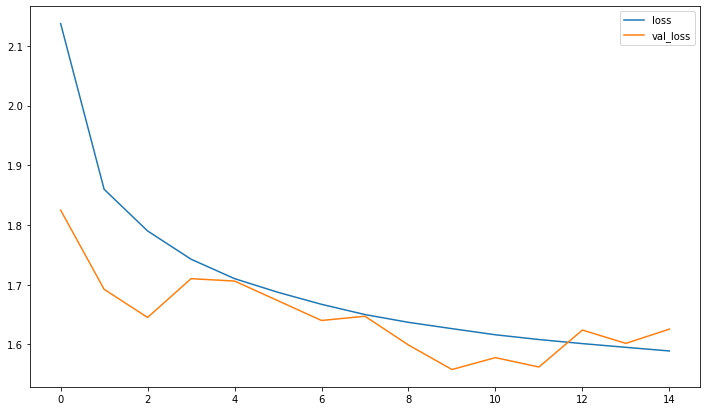

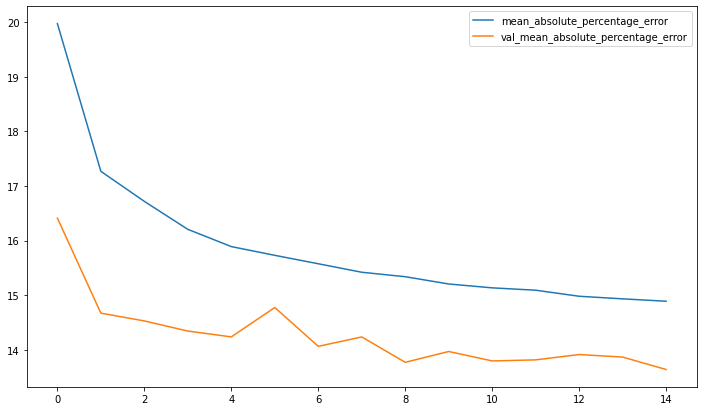

time: 357 ms (started: 2022-09-26 15:24:59 +00:00)


In [ ]:
loss_val=pd.DataFrame(history.history)
loss_val[['loss', 'val_loss']].plot(figsize=(12,7))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(12,7))

In [ ]:
CI_95()

Confidence Intervals:

MSE : [12.938336351743516, 15.839712227154596]
MAE : [1.514503635694478, 1.7768388611774701]
MAPE : [12.966442906467012, 15.565474284084747]
time: 9.15 ms (started: 2022-09-26 15:24:59 +00:00)


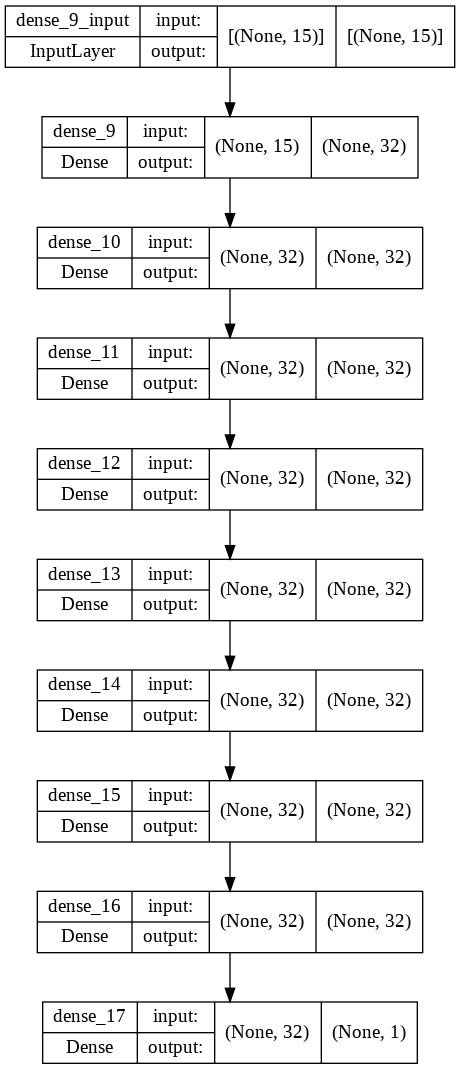

time: 687 ms (started: 2022-09-26 16:12:41 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.01)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 12, batch_size = 128, validation_split=0.2, shuffle=True, callbacks=[callback])

Epoch 1/12
5935/5935 [==============================] - 27s 4ms/step - loss: 3.0475 - mean_absolute_percentage_error: 24.2210 - mean_absolute_error: 3.0475 - mean_squared_error: 44.8432 - val_loss: 1.8334 - val_mean_absolute_percentage_error: 15.6900 - val_mean_absolute_error: 1.8334 - val_mean_squared_error: 15.9347 - lr: 9.9005e-04
Epoch 2/12
5935/5935 [==============================] - 25s 4ms/step - loss: 1.7652 - mean_absolute_percentage_error: 16.0068 - mean_absolute_error: 1.7652 - mean_squared_error: 14.4425 - val_loss: 1.7200 - val_mean_absolute_percentage_error: 15.7919 - val_mean_absolute_error: 1.7200 - val_mean_squared_error: 13.8334 - lr: 9.8020e-04
Epoch 3/12
5935/5935 [==============================] - 25s 4ms/step - loss: 1.7069 - mean_absolute_percentage_error: 15.5468 - mean_absolute_error: 1.7069 - mean_squared_error: 13.7309 - val_loss: 1.6827 - val_mean_absolute_percentage_error: 14.7103 - val_mean_absolute_error: 1.6827 - val_mean_squared_error: 13.9056 - lr: 9.7

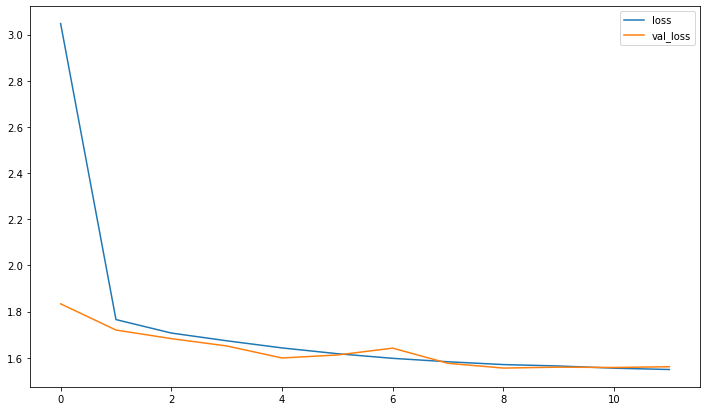

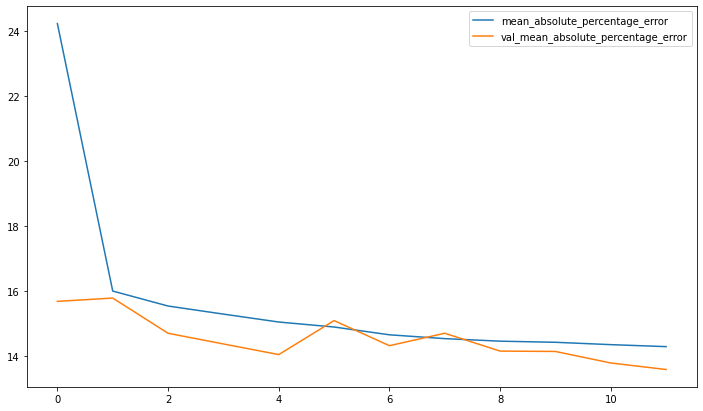

time: 364 ms (started: 2022-09-26 16:18:07 +00:00)


In [ ]:
loss_val=pd.DataFrame(history.history)
loss_val[['loss', 'val_loss']].plot(figsize=(12,7))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(12,7))

In [ ]:
CI_95()

Confidence Intervals:

MSE : [10.97154023974363, 15.150159252393008]
MAE : [1.4714168465042432, 1.7867000742848398]
MAPE : [13.237610320473715, 15.842147211010252]
time: 3.27 ms (started: 2022-09-26 16:28:09 +00:00)


### D. Early Stopping

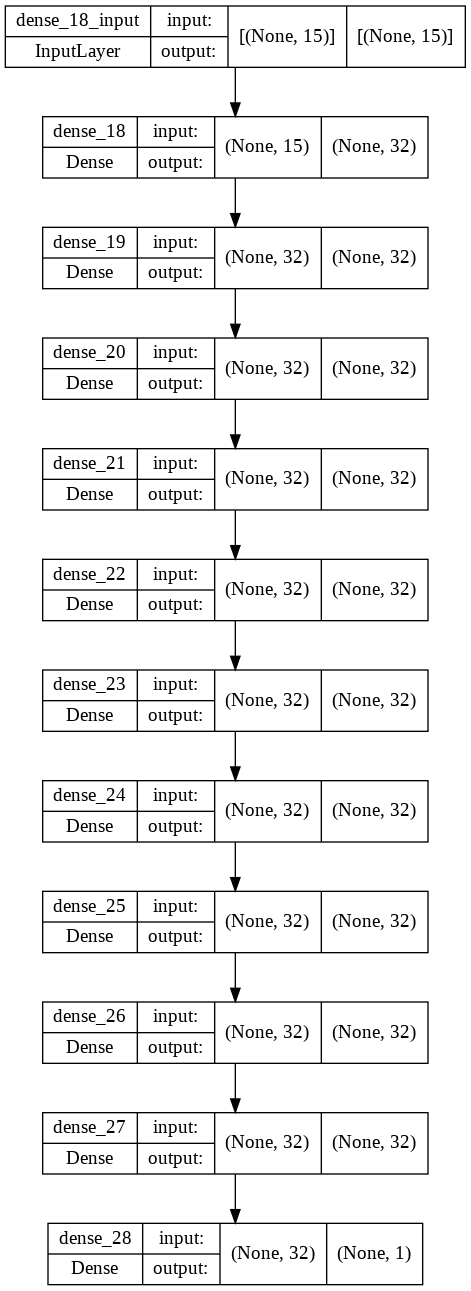

time: 231 ms (started: 2022-09-26 16:28:30 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.05)

callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error', patience=3)

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 12, batch_size = 80, validation_split=0.2, shuffle=True, callbacks=[callback1, callback2])

Epoch 1/12
9496/9496 [==============================] - 40s 4ms/step - loss: 1.9920 - mean_absolute_percentage_error: 18.4567 - mean_absolute_error: 1.9920 - mean_squared_error: 17.4477 - val_loss: 1.7451 - val_mean_absolute_percentage_error: 14.9586 - val_mean_absolute_error: 1.7451 - val_mean_squared_error: 14.2539 - lr: 9.5123e-04
Epoch 2/12
9496/9496 [==============================] - 38s 4ms/step - loss: 1.6840 - mean_absolute_percentage_error: 15.4312 - mean_absolute_error: 1.6840 - mean_squared_error: 13.0750 - val_loss: 1.6320 - val_mean_absolute_percentage_error: 14.3852 - val_mean_absolute_error: 1.6320 - val_mean_squared_error: 12.9762 - lr: 9.0484e-04
Epoch 3/12
9496/9496 [==============================] - 39s 4ms/step - loss: 1.6355 - mean_absolute_percentage_error: 15.0415 - mean_absolute_error: 1.6355 - mean_squared_error: 12.5685 - val_loss: 1.6833 - val_mean_absolute_percentage_error: 14.2662 - val_mean_absolute_error: 1.6833 - val_mean_squared_error: 13.5626 - lr: 8.6

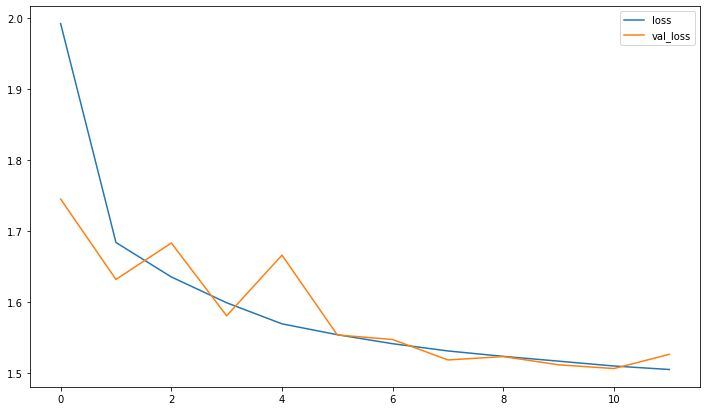

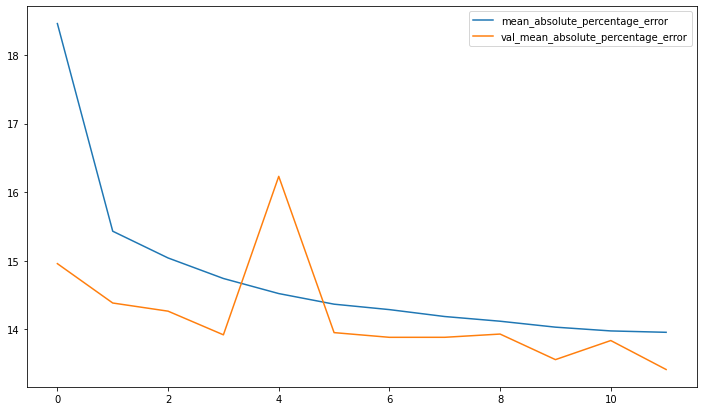

time: 339 ms (started: 2022-09-26 16:36:13 +00:00)


In [ ]:
loss_val=pd.DataFrame(history.history)
loss_val[['loss', 'val_loss']].plot(figsize=(12,7))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(12,7))

In [ ]:
CI_95()

Confidence Intervals:

MSE : [10.262192995708038, 13.943319845834523]
MAE : [1.4338197610132422, 1.732186267638949]
MAPE : [12.76630007707867, 15.605985606871117]
time: 3.99 ms (started: 2022-09-26 16:36:14 +00:00)


### Dropout Rate

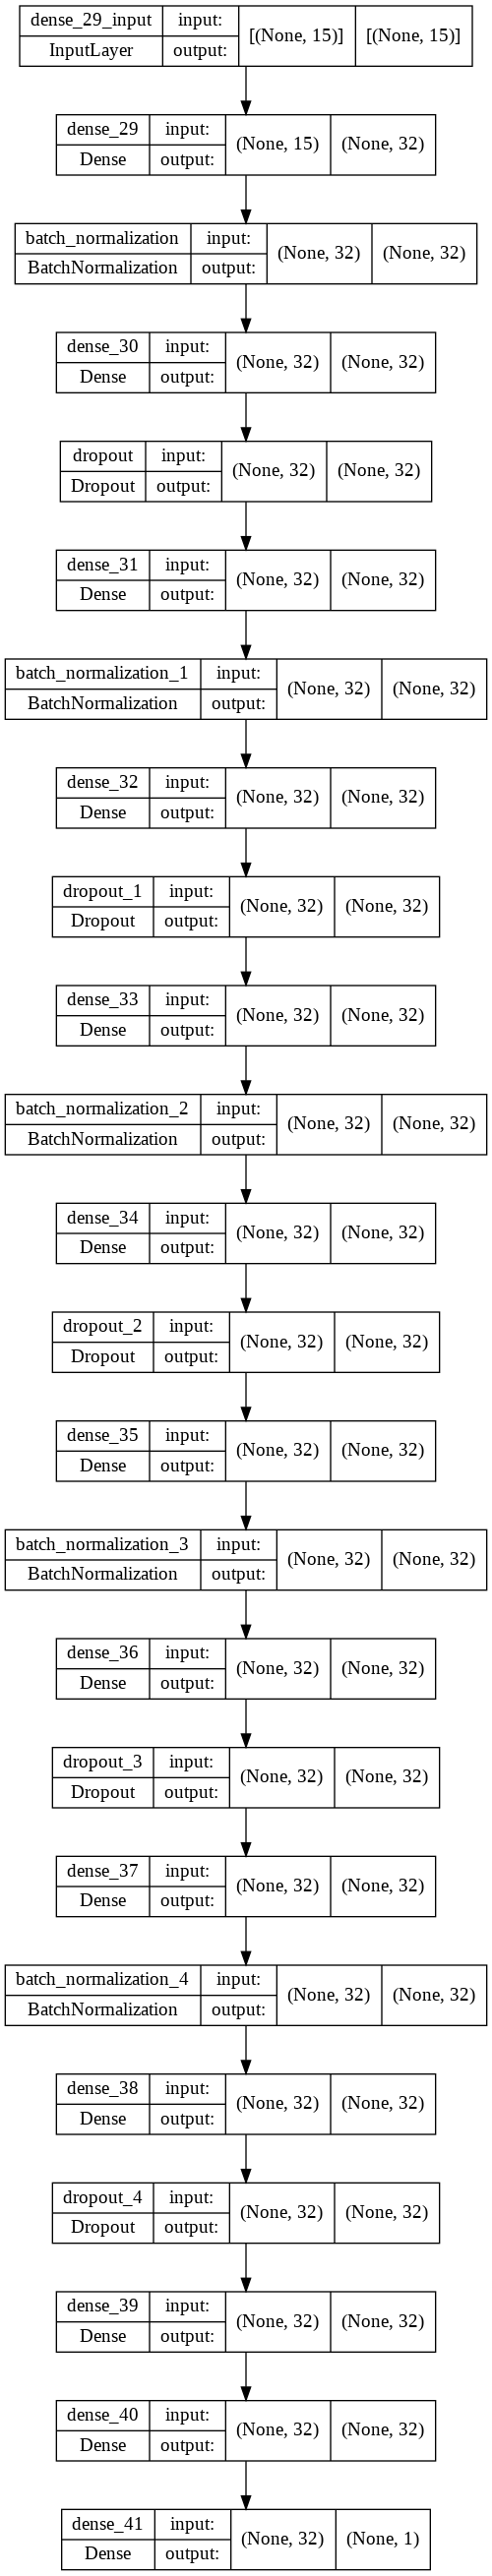

time: 375 ms (started: 2022-09-26 16:36:14 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dropout(0.3),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dropout(0.3),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dropout(0.3),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dropout(0.3),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dropout(0.3),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(32, activation=activations.elu),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.05)

callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_split=0.2, shuffle=True, callbacks=[callback1])

Epoch 1/10
5935/5935 [==============================] - 47s 8ms/step - loss: 2.7449 - mean_absolute_percentage_error: 24.4156 - mean_absolute_error: 2.7449 - mean_squared_error: 27.3861 - val_loss: 2.4713 - val_mean_absolute_percentage_error: 18.1780 - val_mean_absolute_error: 2.4713 - val_mean_squared_error: 29.0556 - lr: 9.5123e-04
Epoch 2/10
5935/5935 [==============================] - 43s 7ms/step - loss: 2.2178 - mean_absolute_percentage_error: 19.5357 - mean_absolute_error: 2.2178 - mean_squared_error: 19.2485 - val_loss: 2.5535 - val_mean_absolute_percentage_error: 17.3174 - val_mean_absolute_error: 2.5535 - val_mean_squared_error: 30.8893 - lr: 9.0484e-04
Epoch 3/10
5935/5935 [==============================] - 45s 8ms/step - loss: 2.1318 - mean_absolute_percentage_error: 18.9203 - mean_absolute_error: 2.1318 - mean_squared_error: 18.0128 - val_loss: 2.5687 - val_mean_absolute_percentage_error: 17.3016 - val_mean_absolute_error: 2.5687 - val_mean_squared_error: 31.2773 - lr: 8.6

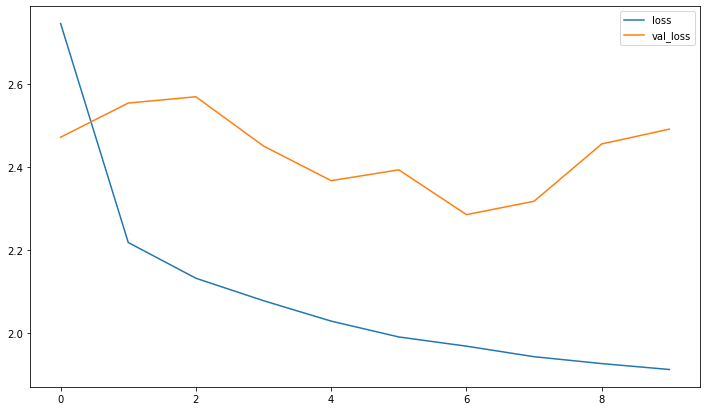

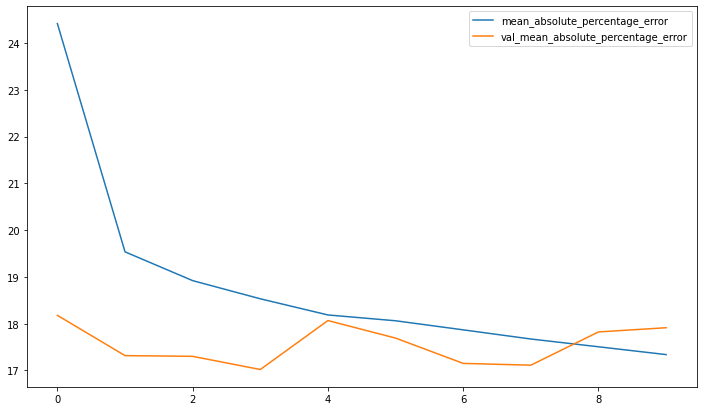

time: 338 ms (started: 2022-09-26 16:44:38 +00:00)


In [ ]:
loss_val=pd.DataFrame(history.history)
loss_val[['loss', 'val_loss']].plot(figsize=(12,7))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(12,7))

In [ ]:
CI_95()

Confidence Intervals:

MSE : [23.30688712664395, 31.900509952823825]
MAE : [2.2599486906842023, 2.6102115075274672]
MAPE : [16.76519825013917, 18.350256232893052]
time: 8.48 ms (started: 2022-09-26 16:44:38 +00:00)


### E. Nadam Optimizer

Epoch 1/25
5935/5935 [==============================] - 35s 6ms/step - loss: 2.8774 - mean_absolute_percentage_error: 22.6306 - mean_absolute_error: 2.8774 - mean_squared_error: 41.0491 - val_loss: 1.8918 - val_mean_absolute_percentage_error: 15.6553 - val_mean_absolute_error: 1.8918 - val_mean_squared_error: 17.0917
Epoch 2/25
5935/5935 [==============================] - 34s 6ms/step - loss: 1.7763 - mean_absolute_percentage_error: 15.9775 - mean_absolute_error: 1.7763 - mean_squared_error: 14.6828 - val_loss: 1.7066 - val_mean_absolute_percentage_error: 14.9763 - val_mean_absolute_error: 1.7066 - val_mean_squared_error: 14.0532
Epoch 3/25
5935/5935 [==============================] - 34s 6ms/step - loss: 1.6939 - mean_absolute_percentage_error: 15.4016 - mean_absolute_error: 1.6939 - mean_squared_error: 13.6195 - val_loss: 1.6573 - val_mean_absolute_percentage_error: 14.8280 - val_mean_absolute_error: 1.6573 - val_mean_squared_error: 13.3290
Epoch 4/25
5935/5935 [=====================

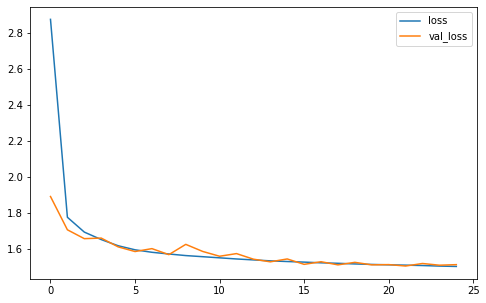

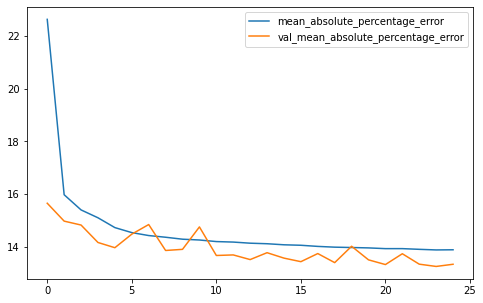

time: 14min 23s (started: 2022-09-26 16:44:52 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Nadam(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

history = model.fit(X_train, y_train, epochs = 25, batch_size = 128, validation_split=0.2, shuffle=True)

loss_val=pd.DataFrame(history.history)
loss_val[-1:]

loss_val[['loss', 'val_loss']].plot(figsize=(8,5))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(8,5))

CI_95()

### Adamax Optimizer

Epoch 1/25
5935/5935 [==============================] - 23s 4ms/step - loss: 4.0262 - mean_absolute_percentage_error: 31.7137 - mean_absolute_error: 4.0262 - mean_squared_error: 66.4378 - val_loss: 2.3180 - val_mean_absolute_percentage_error: 19.9048 - val_mean_absolute_error: 2.3180 - val_mean_squared_error: 24.9201
Epoch 2/25
5935/5935 [==============================] - 22s 4ms/step - loss: 2.0451 - mean_absolute_percentage_error: 17.5645 - mean_absolute_error: 2.0451 - mean_squared_error: 19.3716 - val_loss: 2.0065 - val_mean_absolute_percentage_error: 19.8711 - val_mean_absolute_error: 2.0065 - val_mean_squared_error: 16.0173
Epoch 3/25
5935/5935 [==============================] - 22s 4ms/step - loss: 1.8108 - mean_absolute_percentage_error: 16.4666 - mean_absolute_error: 1.8108 - mean_squared_error: 14.8448 - val_loss: 1.7568 - val_mean_absolute_percentage_error: 15.7730 - val_mean_absolute_error: 1.7568 - val_mean_squared_error: 14.4274
Epoch 4/25
5935/5935 [=====================

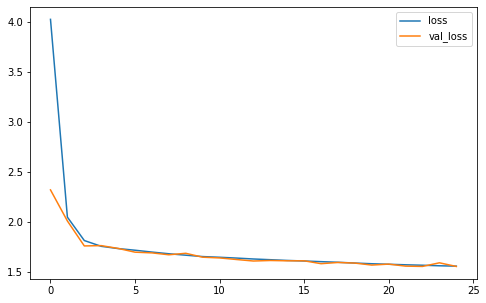

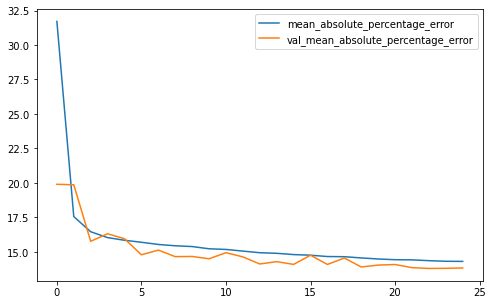

time: 10min 23s (started: 2022-09-26 16:59:16 +00:00)


In [ ]:
model = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(32, activation=activations.softsign),
                                       tf.keras.layers.Dense(1, activation=activations.relu)
])

model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adamax(),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
                        )

model.build(input_shape=(None, 15))

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

history = model.fit(X_train, y_train, epochs = 25, batch_size = 128, validation_split=0.2, shuffle=True)

loss_val=pd.DataFrame(history.history)
loss_val[-1:]

loss_val[['loss', 'val_loss']].plot(figsize=(8,5))
loss_val[['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']].plot(figsize=(8,5))

CI_95()